In [66]:
import pandas as pd
import pickle
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
#from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
#from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.qda import QDA
from sklearn.svm import SVC
from sklearn.metrics import precision_recall_curve, roc_curve, auc  
from sklearn.metrics import classification_report  
from sklearn.cross_validation import train_test_split
from helper import xcols
%matplotlib inline  

### 1. 准备数据

### (1). 导入训练集

In [67]:
header = ['dev_id', 'post_id', 'stat_view', 'stat_click', 'max_stat_date', 'min_stat_date', 'ds', 'stat_view_1'  ,                                                                    
    'stat_click_1', 'stat_view_2', 'stat_click_2', 'p1', 'p1_time', 'p2', 'p2_time', 'ucnt1', 'upct1', 'ucnt2',
    'upct2', 'pcnt1', 'ppct1', 'pcnt2', 'ppct2', 'rela_p1_cnt', 'rela_p2_cnt', 'n'
]  

In [68]:
df = pd.read_csv('data/model_detail.csv', names= header)

###  (2). 数据混合

In [69]:
c1 = df['p1'] == 1
c2 = df['p1'] == 0
df = pd.concat([df[c1], df[c2].sample(len(df[c1]))])

### (3). 拆分建模和测试集

In [70]:
train, test = train_test_split(df, test_size=.2)
print 'len(train) = ', len(train)
print 'len(test) = ', len(test)

len(train) =  353582
len(test) =  88396


### 2. 建模

#### (1). 定义建模字段

In [71]:
"""
xcols = [
    'stat_view', 'stat_click', 'stat_view_1', 'stat_click_1', 'stat_view_2', 'stat_click_2', 
    'ucnt1', 'upct1', 'ucnt2', 'upct2', 'pcnt1', 'ppct1', 'pcnt2', 'ppct2', 'rela_p1_cnt', 'rela_p2_cnt',
]
""" 
ycol = 'p1'

In [72]:
train_x = train[xcols]
train_y = train[ycol]
test_x = test[xcols]

In [73]:
train_x[train_x['upct2'].isnull()]

,ucnt1,upct1,ucnt2,upct2,pcnt1,ppct1,pcnt2,ppct2,rela_p1_cnt,rela_p2_cnt


#### (2). 创建分类器

In [74]:
# classifier = QDA()
# classifier = RandomForestClassifier(max_depth=6, n_estimators=10, max_features=4)
# classifier = RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)
# classifier =DecisionTreeClassifier(max_depth=5)
# classifier = SVC(probability=True)   # ***慢 ***
#classifier = SVC(kernel="linear", C=0.025)
# classifier = SVC(gamma=2, C=1)
# classifier = KNeighborsClassifier(3)  # ***慢 ***
# classifier = AdaBoostClassifier()
classifier = GaussianNB()
# classifier = MultinomialNB()
# classifier = BernoulliNB()

#### (3). 建模并获取结果

In [75]:
classifier.fit(train_x, train_y) 
proba = classifier.predict_proba(test_x)
result = test
result['pct']  = proba[:,1]

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [76]:
proba

array([[  4.92522975e-81,   1.00000000e+00],
       [  2.18612454e-01,   7.81387546e-01],
       [  9.99999920e-01,   8.03969377e-08],
       ..., 
       [  8.50039497e-01,   1.49960503e-01],
       [  2.13157797e-36,   1.00000000e+00],
       [  9.31809873e-01,   6.81901270e-02]])

#### (4). 整理结果数据

In [77]:
result = result[['dev_id', 'post_id', 'p1', 'pct']]
result = result.sort_values('pct', ascending=False)
result['n'] = range(1, len(result)+1)
result['cumsum'] =  result['p1'].cumsum() 
stat = result['cumsum'] / result['n']

#### (5). 作图

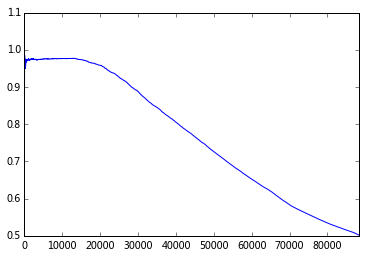

In [78]:
stat.reset_index(drop=True).plot()

### 3. 保存分类器

In [79]:
pickle.dump(classifier, open('p1.pk', 'wb'))